Loading TFLite model: tealeaf.tflite...
Model Loaded Successfully!
   Input Shape: [  1 224 224   3]
   Input Type: <class 'numpy.float32'>
Found 9 images. Starting inference...



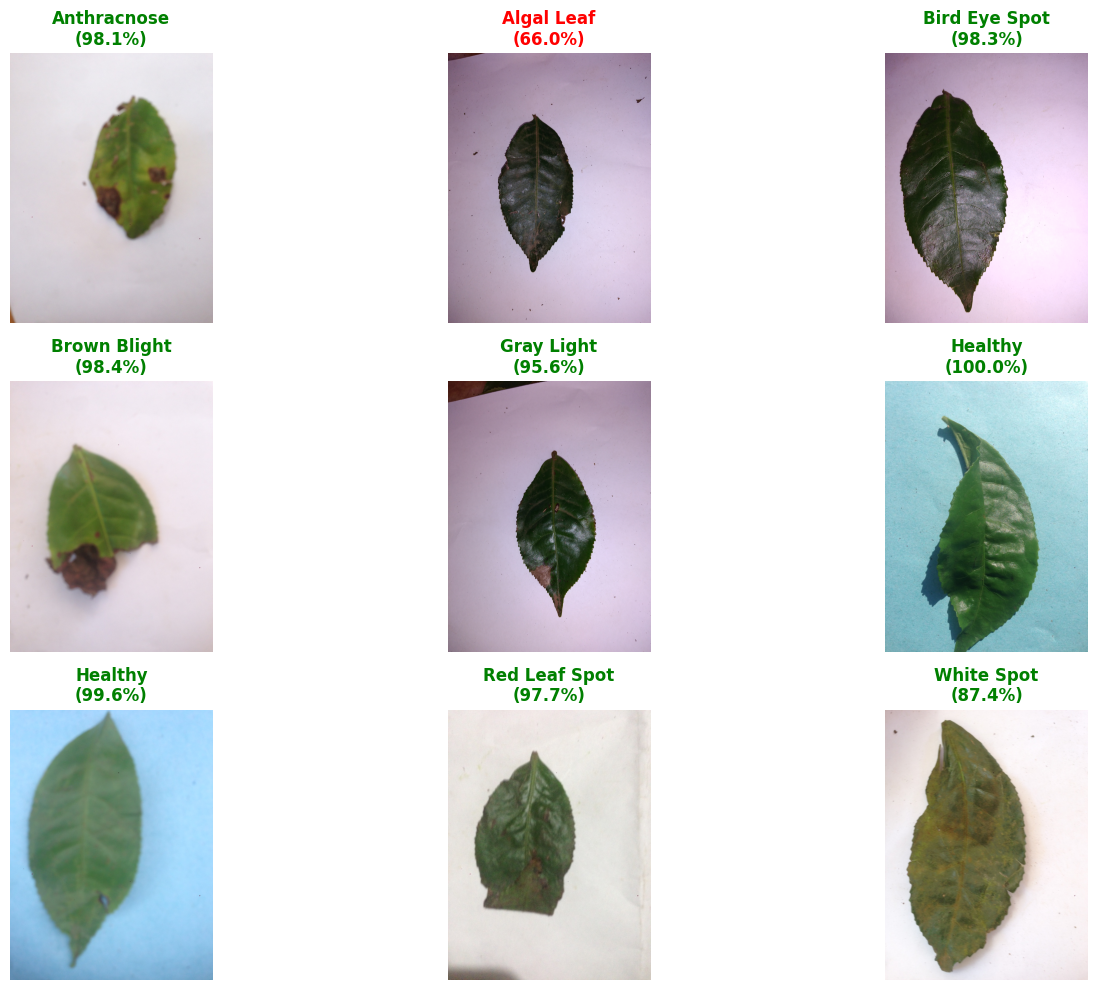


Inference Complete.


In [ ]:
# ==========================================
# 1. SETUP & IMPORTS
# ==========================================
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

# ==========================================
# 2. CONFIGURATION
# ==========================================
MODEL_PATH = 'tealeaf.tflite'   # Your quantized model
TEST_DIR = 'test images'             # Folder containing your test images
IMG_SIZE = (224, 224)

# Define your class names (Must match your training order!)
# Update this list if your classes are different
CLASS_NAMES = [
    'Algal Leaf', 'Anthracnose', 'Bird Eye Spot', 'Brown Blight', 
    'Gray Light', 'Healthy', 'Red Leaf Spot', 'White Spot'
]

# Check if model exists
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Model file not found: {MODEL_PATH}")

# ==========================================
# 3. LOAD TFLITE MODEL
# ==========================================
print(f"Loading TFLite model: {MODEL_PATH}...")
interpreter = tf.lite.Interpreter(model_path=MODEL_PATH)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Model Loaded Successfully!")
print(f"   Input Shape: {input_details[0]['shape']}")
print(f"   Input Type: {input_details[0]['dtype']}")

# ==========================================
# 4. INFERENCE FUNCTION
# ==========================================
def predict_image(image_path):
    # 1. Read Image
    original_img = cv2.imread(image_path)
    if original_img is None:
        print(f"⚠️ Could not read image: {image_path}")
        return None, None, None

    # 2. Convert to RGB (OpenCV is BGR by default)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    # 3. Resize to Model Input Size
    img_resized = cv2.resize(original_img, IMG_SIZE)

    # 4. Preprocess (Standard MobileNetV3 Scaling)
    # We use expand_dims to add the batch dimension (1, 224, 224, 3)
    input_data = np.expand_dims(img_resized, axis=0).astype(np.float32)
    
    # Crucial: Apply the same preprocessing function used in training
    input_data = preprocess_input(input_data)

    # 5. Set Tensor & Run Inference
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()

    # 6. Get Result
    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    # 7. Decode Prediction
    prediction_idx = np.argmax(output_data[0])
    confidence = np.max(output_data[0]) * 100
    predicted_label = CLASS_NAMES[prediction_idx]

    return original_img, predicted_label, confidence

# ==========================================
# 5. RUN ON ALL TEST IMAGES
# ==========================================
# Get list of images
image_files = [f for f in os.listdir(TEST_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

if not image_files:
    print(f"No images found in '{TEST_DIR}'. Please add some .jpg or .png files.")
else:
    print(f"Found {len(image_files)} images. Starting inference...\n")
    
    plt.figure(figsize=(15, 10))
    
    # Loop through first 9 images (to fit in a grid)
    for i, file_name in enumerate(image_files[:9]):
        full_path = os.path.join(TEST_DIR, file_name)
        
        img, label, conf = predict_image(full_path)
        
        if img is not None:
            plt.subplot(3, 3, i + 1)
            plt.imshow(img)
            plt.axis('off')
            
            # Color code title: Green for High Conf, Red for Low
            title_color = 'green' if conf > 70 else 'red'
            plt.title(f"{label}\n({conf:.1f}%)", color=title_color, fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.savefig("results/inference_results.png", dpi=150)
    plt.show()

print("\nInference Complete.")
